In [ ]:
# Load library
import os
import pandas as pd
import numpy as np
from fancyimpute import KNN
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
import copy

In [ ]:
## Set the working directory
os.chdir("C:\Malvika\Edwisor\Edwisor\Project\Project 1_Malvika")

In [ ]:
## Check the current working directory
os.getcwd()

In [64]:
## Load the data 
Train_data = pd.read_csv("train_cab.csv")
print(type(Train_data))
Train_data.shape #(16067, 7)

<class 'pandas.core.frame.DataFrame'>


(16067, 7)

In [65]:
## Viewing top entries
Train_data.head(5)

fare_amount          pickup_datetime  pickup_longitude  pickup_latitude  \
0         4.5  2009-06-15 17:26:21 UTC        -73.844311        40.721319   
1        16.9  2010-01-05 16:52:16 UTC        -74.016048        40.711303   
2         5.7  2011-08-18 00:35:00 UTC        -73.982738        40.761270   
3         7.7  2012-04-21 04:30:42 UTC        -73.987130        40.733143   
4         5.3  2010-03-09 07:51:00 UTC        -73.968095        40.768008   

   dropoff_longitude  dropoff_latitude  passenger_count  
0         -73.841610         40.712278              1.0  
1         -73.979268         40.782004              1.0  
2         -73.991242         40.750562              2.0  
3         -73.991567         40.758092              1.0  
4         -73.956655         40.783762              1.0

In [66]:
# Summary of all the variables
Train_data.describe(include='all')

fare_amount          pickup_datetime  pickup_longitude  \
count        16043                    16067      16067.000000   
unique         468                    16021               NaN   
top            6.5  2013-09-10 19:03:00 UTC               NaN   
freq           759                        2               NaN   
mean           NaN                      NaN        -72.462787   
std            NaN                      NaN         10.578384   
min            NaN                      NaN        -74.438233   
25%            NaN                      NaN        -73.992156   
50%            NaN                      NaN        -73.981698   
75%            NaN                      NaN        -73.966838   
max            NaN                      NaN         40.766125   

        pickup_latitude  dropoff_longitude  dropoff_latitude  passenger_count  
count      16067.000000       16067.000000      16067.000000     16012.000000  
unique              NaN                NaN               NaN              NaN  
top                 NaN                NaN               NaN              NaN  
freq                NaN                NaN               NaN              NaN  
mean          39.914725         -72.462328         39.897906         2.625070  
std            6.826587          10.575062          6.187087        60.844122  
min          -74.006893         -74.429332        -74.006377         0.000000  
25%           40.734927         -73.991182         40.734651         1.000000  
50%           40.752603         -73.980172         40.753567         1.000000  
75%           40.767381         -73.963643         40.768013         2.000000  
max          401.083332          40.802437         41.366138      5345.000000

In [67]:
## Checking the datatypes for each variable
Train_data.dtypes

fare_amount           object
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      float64
dtype: object

In [68]:
# ***************** Exploratory data Analysis ************

## Convert data into proper data type
Train_data['fare_amount'] = pd.to_numeric(Train_data['fare_amount'], errors='coerce')
Train_data['pickup_datetime'] = pd.to_datetime(Train_data['pickup_datetime'], errors='coerce')
Train_data['pickup_datetime'] =  pd.to_datetime(Train_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S UTC')
Train_data.dtypes

fare_amount                      float64
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                  float64
dtype: object

In [69]:
#**************** Data Cleaning **************************

# Summary of passenger count variables
print(Train_data["passenger_count"].describe())

## Removing the values with passenger count of 0 & greater than 8.
Train_data = Train_data.drop(Train_data[Train_data["passenger_count"] > 8 ].index, axis=0)
Train_data = Train_data.drop(Train_data[Train_data["passenger_count"] == 0 ].index, axis=0)
print(Train_data["passenger_count"].describe())

count    16012.000000
mean         2.625070
std         60.844122
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max       5345.000000
Name: passenger_count, dtype: float64
count    15935.000000
mean         1.649540
std          1.265914
min          0.120000
25%          1.000000
50%          1.000000
75%          2.000000
max          6.000000
Name: passenger_count, dtype: float64


In [70]:
# Summary of fare_amount variables
print(Train_data["fare_amount"].describe())

#deleting negative values from fare_amount as amount can't be negative and greater than 500
index_fc = Train_data.loc[Train_data.fare_amount > 100,:].index
Train_data.drop(index_fc, axis = 0, inplace = True)

index_fc1 = Train_data.loc[Train_data.fare_amount<0, :].index
Train_data.drop(index_fc1, axis = 0, inplace = True)

print(Train_data["fare_amount"].describe())

count    15966.000000
mean        15.043831
std        431.483944
min         -3.000000
25%          6.000000
50%          8.500000
75%         12.500000
max      54343.000000
Name: fare_amount, dtype: float64
count    15954.000000
mean        11.278595
std          9.388775
min          0.000000
25%          6.000000
50%          8.500000
75%         12.500000
max         96.000000
Name: fare_amount, dtype: float64


In [71]:
#Changing the values to its absolute for easier calculation
Train_data = Train_data[abs(Train_data["pickup_latitude"]) < 90] 
Train_data = Train_data[abs(Train_data["dropoff_latitude"]) < 90] 
Train_data = Train_data[abs(Train_data["pickup_longitude"]) < 180]
Train_data = Train_data[abs(Train_data["dropoff_longitude"]) < 180]
Train_data.shape # (15977, 7)

(15977, 7)

In [72]:
# ************************** Feature Engineering*************************

### Seperate Pickup_datetime column into separate fields year, month, day of the week, etc

Train_data['Year'] = Train_data['pickup_datetime'].dt.year
Train_data['Month'] = Train_data['pickup_datetime'].dt.month
Train_data['Date'] = Train_data['pickup_datetime'].dt.day
Train_data['Day'] = Train_data['pickup_datetime'].dt.dayofweek
Train_data['Hour'] = Train_data['pickup_datetime'].dt.hour
Train_data['Minute'] = Train_data['pickup_datetime'].dt.minute
Train_data.dtypes

fare_amount                      float64
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                  float64
Year                             float64
Month                            float64
Date                             float64
Day                              float64
Hour                             float64
Minute                           float64
dtype: object

In [73]:
# We need to calculate the distance Using the haversine formula and we will create a new variable called distance
from math import radians, cos, sin, asin, sqrt

def haversine(a):
    lon1=a[0]
    lat1=a[1]
    lon2=a[2]
    lat2=a[3]
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c =  2 * asin(sqrt(a))
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

In [74]:
## Using pickup & Dropoff lat & long calculating Distance 
Train_data['Distance'] = Train_data[['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']].apply(haversine,axis=1)
Train_data.head(5)

fare_amount           pickup_datetime  pickup_longitude  pickup_latitude  \
0          4.5 2009-06-15 17:26:21+00:00        -73.844311        40.721319   
1         16.9 2010-01-05 16:52:16+00:00        -74.016048        40.711303   
2          5.7 2011-08-18 00:35:00+00:00        -73.982738        40.761270   
3          7.7 2012-04-21 04:30:42+00:00        -73.987130        40.733143   
4          5.3 2010-03-09 07:51:00+00:00        -73.968095        40.768008   

   dropoff_longitude  dropoff_latitude  passenger_count    Year  Month  Date  \
0         -73.841610         40.712278              1.0  2009.0    6.0  15.0   
1         -73.979268         40.782004              1.0  2010.0    1.0   5.0   
2         -73.991242         40.750562              2.0  2011.0    8.0  18.0   
3         -73.991567         40.758092              1.0  2012.0    4.0  21.0   
4         -73.956655         40.783762              1.0  2010.0    3.0   9.0   

   Day  Hour  Minute  Distance  
0  0.0  17.0    26.0  1.030764  
1  1.0  16.0    52.0  8.450134  
2  3.0   0.0    35.0  1.389525  
3  5.0   4.0    30.0  2.799270  
4  1.0   7.0    51.0  1.999157

In [75]:
## Feature selection 
drop = ['pickup_datetime','pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude', 'Minute']
Train_data = Train_data.drop(drop, axis = 1)

In [76]:
Train_data.head(5)

fare_amount  passenger_count    Year  Month  Date  Day  Hour  Distance
0          4.5              1.0  2009.0    6.0  15.0  0.0  17.0  1.030764
1         16.9              1.0  2010.0    1.0   5.0  1.0  16.0  8.450134
2          5.7              2.0  2011.0    8.0  18.0  3.0   0.0  1.389525
3          7.7              1.0  2012.0    4.0  21.0  5.0   4.0  2.799270
4          5.3              1.0  2010.0    3.0   9.0  1.0   7.0  1.999157

In [77]:
#****************** Missing value analysis ****************

Total = Train_data.isnull().sum().sort_values(ascending=False)
percent = ((Train_data.isnull().sum()/Train_data.isnull().count()).sort_values(ascending=False))*100
missing_data = pd.concat([Total, percent], axis=1, keys=['Total', 'Missing Percent'])
missing_data = missing_data.sort_values('Total', ascending = False)
missing_data

Total  Missing Percent
passenger_count     55         0.344245
fare_amount         24         0.150216
Hour                 1         0.006259
Day                  1         0.006259
Date                 1         0.006259
Month                1         0.006259
Year                 1         0.006259
Distance             0         0.000000

In [ ]:
# Create Missing value to check whick method is suitable for impuation as our missing value is less than 30%
#Train_data['fare_amount'].loc[10]=np.nan

In [ ]:
# Imputation Method
# Actual value = 5.3
# Mean = 15.01
# Median = 8.5
# KNN Imputation = 5.3 Hence will use KNN imputation for missing value

In [78]:
# Imputing with Mean
#Train_data['fare_amount'] = Train_data['fare_amount'].fillna(Train_data['fare_amount'].mean())
#Train_data.head(20)

#Imputing with Median
#Train_data['fare_amount'] = Train_data['fare_amount'].fillna(Train_data['fare_amount'].median())
#Train_data.head(20)

#Imputing using KNN
Train_data=pd.DataFrame(KNN(k=5).fit_transform(Train_data),columns=Train_data.columns, index=Train_data.index)
Train_data.head(20)

Imputing row 1/15977 with 0 missing, elapsed time: 40.306
Imputing row 101/15977 with 0 missing, elapsed time: 40.310
Imputing row 201/15977 with 0 missing, elapsed time: 40.311
Imputing row 301/15977 with 0 missing, elapsed time: 40.312
Imputing row 401/15977 with 0 missing, elapsed time: 40.312
Imputing row 501/15977 with 0 missing, elapsed time: 40.313
Imputing row 601/15977 with 0 missing, elapsed time: 40.314
Imputing row 701/15977 with 0 missing, elapsed time: 40.315
Imputing row 801/15977 with 0 missing, elapsed time: 40.316
Imputing row 901/15977 with 0 missing, elapsed time: 40.317
Imputing row 1001/15977 with 0 missing, elapsed time: 40.317
Imputing row 1101/15977 with 0 missing, elapsed time: 40.318
Imputing row 1201/15977 with 0 missing, elapsed time: 40.318
Imputing row 1301/15977 with 0 missing, elapsed time: 40.319
Imputing row 1401/15977 with 0 missing, elapsed time: 40.320
Imputing row 1501/15977 with 0 missing, elapsed time: 40.321
Imputing row 1601/15977 with 0 missi

fare_amount  passenger_count    Year  Month  Date  Day  Hour  Distance
0      4.500000              1.0  2009.0    6.0  15.0  0.0  17.0  1.030764
1     16.900000              1.0  2010.0    1.0   5.0  1.0  16.0  8.450134
2      5.700000              2.0  2011.0    8.0  18.0  3.0   0.0  1.389525
3      7.700000              1.0  2012.0    4.0  21.0  5.0   4.0  2.799270
4      5.300000              1.0  2010.0    3.0   9.0  1.0   7.0  1.999157
5     12.100000              1.0  2011.0    1.0   6.0  3.0   9.0  3.787239
6      7.500000              1.0  2012.0   11.0  20.0  1.0  20.0  1.555807
7     16.500000              1.0  2012.0    1.0   4.0  2.0  17.0  4.155444
8      7.066107              1.0  2012.0   12.0   3.0  0.0  13.0  1.253232
9      8.900000              2.0  2009.0    9.0   2.0  2.0   1.0  2.849627
10     5.300000              1.0  2012.0    4.0   8.0  6.0   7.0  1.374577
11     5.500000              3.0  2012.0   12.0  24.0  0.0  11.0  0.000000
12     4.100000              2.0  2009.0   11.0   6.0  4.0   1.0  0.717767
13     7.000000              1.0  2013.0    7.0   2.0  1.0  19.0  2.019384
14     7.700000              2.0  2011.0    4.0   5.0  1.0  17.0  1.671445
15     5.000000              1.0  2013.0   11.0  23.0  5.0  12.0  0.000000
16    12.500000              1.0  2014.0    2.0  19.0  2.0   7.0  2.609774
17     5.300000              1.0  2009.0    7.0  22.0  2.0  16.0  1.511904
18     5.300000              1.0  2010.0    7.0   7.0  2.0  14.0  0.921952
19     4.000000              1.0  2014.0   12.0   6.0  5.0  20.0  0.399179

In [79]:
# Outlier Analysis
fig_size = plt.rcParams['figure.figsize']
fig_size[0] = 15
fig_size[1] = 10

plt.subplot(3,4,1)
plt.boxplot(Train_data['fare_amount'])
plt.title('fare_amount')

plt.subplot(3,4,2)
plt.boxplot(Train_data['passenger_count'])
plt.title('passenger_count')


plt.subplot(3,4,3)
plt.boxplot(Train_data['Distance'])
plt.title('Distance')

plt.tight_layout()

In [80]:
# Distance is having outlier so removing it

## Sort distance variable
Train_data['Distance'].sort_values(ascending=False)

9147     8667.542104
8647     8667.497512
2397     8667.454421
472      8667.304968
11653    8666.701504
            ...     
964         0.000000
960         0.000000
958         0.000000
9246        0.000000
4606        0.000000
Name: Distance, Length: 15977, dtype: float64

In [81]:
## Removing outlier from Distance as value greater than 4000 seems to be outlier so will delete values greater than 150
Train_data = Train_data.drop(Train_data[Train_data['Distance'] > 150 ].index, axis=0)
Train_data.shape #(15954,8)

(15954, 8)

In [82]:
# we will remove the rows whose distance value is zero
Counter(Train_data['Distance'] == 0)
Train_data = Train_data.drop(Train_data[Train_data['Distance']== 0].index, axis=0)
Train_data.shape #(15500,8)

(15500, 8)

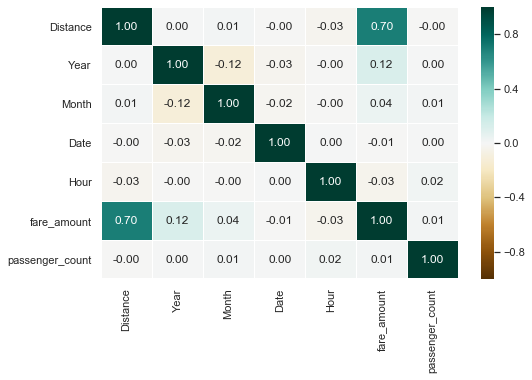

In [83]:
# *********** Correlation Analysis*****************

sns.set(rc={'figure.figsize':(8,5)})
Train_data['passenger_count'] = Train_data['passenger_count'].astype(int)
colname = ['Distance','Year','Month','Date','Hour','fare_amount','passenger_count']
heat_map = Train_data[colname]
sns.heatmap(heat_map.corr(), cmap ='BrBG', fmt='.2f', linewidths = 0.05, vmin=-1.00, vmax=1.00, annot=True)

In [84]:
#Relationship beetween number of passengers and Fare_amount

plt.figure(figsize=(15,5))
plt.scatter(x=Train_data['passenger_count'], y=Train_data['fare_amount'], s=10)
plt.xlabel('No. of Passengers')
plt.ylabel('Fare')
plt.show()

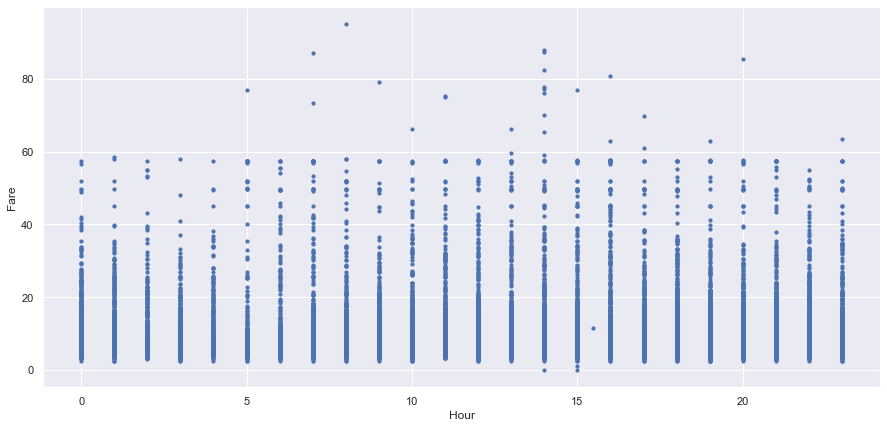

In [85]:
#Relationship between Time and Fare
plt.figure(figsize=(15,7))
plt.scatter(x=Train_data['Hour'], y=Train_data['fare_amount'], s=10)
plt.xlabel('Hour')
plt.ylabel('Fare')
plt.show()

In [86]:
#Relationship between distance and fare 
plt.figure(figsize=(15,7))
plt.scatter(x = Train_data['Distance'],y = Train_data['fare_amount'],c = "g")
plt.xlabel('Distance')
plt.ylabel('Fare')
plt.show()

In [87]:
# Passenger count graph shows most of the passenger lies in which count
plt.figure(figsize=(15,5))
sns.countplot(x="passenger_count", data=Train_data)

fare_amount


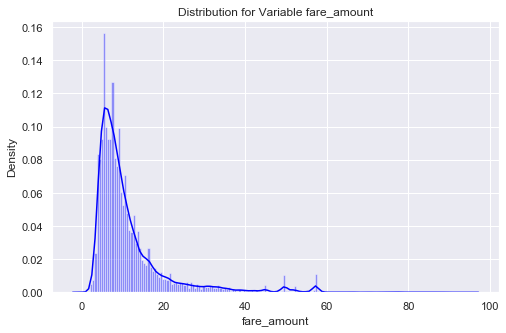

Distance


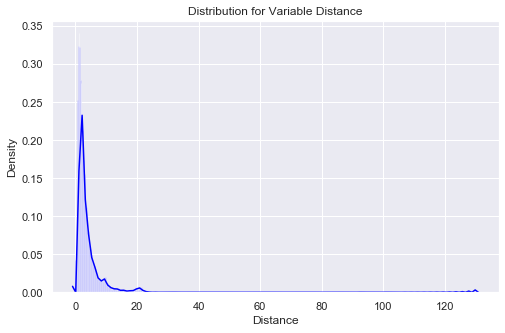

In [88]:
#*********************** Feature Scaling ******************

#Normality check of training data is uniformly distributed or not-
for i in ['fare_amount', 'Distance']:
    print(i)
    sns.distplot(Train_data[i],bins='auto',color='blue')
    plt.title("Distribution for Variable "+i)
    plt.ylabel("Density")
    plt.show()

In [89]:
#since skewness of target variable is high, apply log transform to reduce the skewness-
Train_data['fare_amount'] = np.log1p(Train_data['fare_amount'])

#since skewness of distance variable is high, apply log transform to reduce the skewness-
Train_data['Distance'] = np.log1p(Train_data['Distance'])

fare_amount


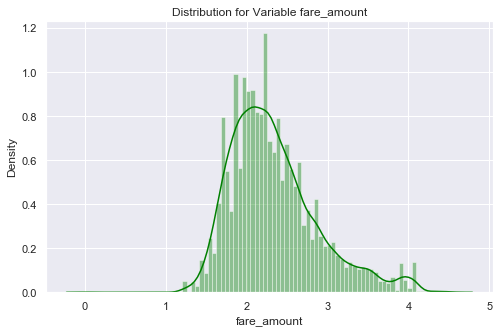

Distance


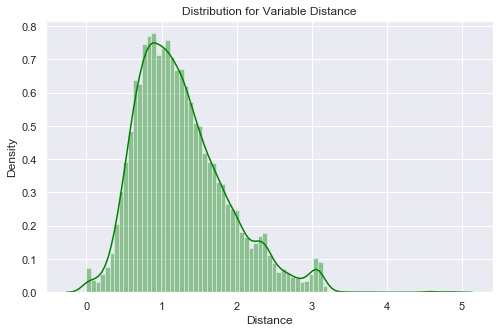

In [90]:
#Normality Re-check to check data is uniformly distributed or not after log transformartion

for i in ['fare_amount', 'Distance']:
    print(i)
    sns.distplot(Train_data[i],bins='auto',color='green')
    plt.title("Distribution for Variable "+i)
    plt.ylabel("Density")
    plt.show()

In [91]:
# ************************* Modeling ******************
# Before implementing any model let's define error matrix to validate the performance of the model
# Our target variable is continues so we use, MAPE, RMSE as data is in time series, MAE, R-square
# defining function to check the performance of the model

def MAPE(actual , predict):
    mape = np.mean(np.abs((actual - predict)/actual) * 100)
    return mape
def RMSE(actual , predict):
    rmse = np.sqrt(metrics.mean_squared_error(actual , predict))
    return rmse
def MSE(actual , predict):
    mse = metrics.mean_squared_error(actual , predict)
    return mse
def Rsq(actual , predict):
    rSq = metrics.r2_score(actual , predict)
    return rSq 

In [92]:
#moving the Fare_amount to last variable
Train_data['Fare_amount']= copy.copy(Train_data['fare_amount'])
Train_data = Train_data.drop(['fare_amount'], axis=1)
Train_data.head(10)

passenger_count    Year  Month  Date  Day  Hour  Distance  Fare_amount
0                1  2009.0    6.0  15.0  0.0  17.0  0.708412     1.704748
1                1  2010.0    1.0   5.0  1.0  16.0  2.246029     2.884801
2                2  2011.0    8.0  18.0  3.0   0.0  0.871095     1.902108
3                1  2012.0    4.0  21.0  5.0   4.0  1.334809     2.163323
4                1  2010.0    3.0   9.0  1.0   7.0  1.098331     1.840550
5                1  2011.0    1.0   6.0  3.0   9.0  1.565954     2.572612
6                1  2012.0   11.0  20.0  1.0  20.0  0.938368     2.140066
7                1  2012.0    1.0   4.0  2.0  17.0  1.640053     2.862201
8                1  2012.0   12.0   3.0  0.0  13.0  0.812365     2.087671
9                2  2009.0    9.0   2.0  2.0   1.0  1.347976     2.292535

In [93]:
#Divide the data into Train & test
train, test = train_test_split(Train_data , test_size = 0.2)
train.shape, test.shape
print(type(train))

<class 'pandas.core.frame.DataFrame'>


In [94]:
# ************ Linear Regression *********
LR_Model = LinearRegression().fit(train.iloc[:,0:7],train.iloc[:,7])
prediction_LR = LR_Model.predict(test.iloc[:,0:7])

# Calculate MAPE, RMSE, MSE, R-sq
print('MAPE: ', MAPE(test.iloc[:,7], prediction_LR))
print('RMSE: ', RMSE(test.iloc[:,7], prediction_LR))
print('MSE: ', MSE(test.iloc[:,7], prediction_LR))
print('R-Square: ', Rsq(test.iloc[:,7], prediction_LR))

print('Perdicted Vs Actual value: ')
prediction_LR[1], test.iloc[1,7]

MAPE:  7.506303705551655
RMSE:  0.2661036152490327
MSE:  0.07081113404860524
R-Square:  0.7593421751698658
Perdicted Vs Actual value: 


(2.092349169391042, 1.840549633397487)

In [95]:
#2. ********************* Decision Tree ********************************

DT_Model = DecisionTreeRegressor(max_depth =5, random_state=123).fit(train.iloc[:,0:7],train.iloc[:,7])
prediction_DT = DT_Model.predict(test.iloc[:,0:7])

# Calculate MAPE, RMSE, MSE, R-sq
print('MAPE: ', MAPE(test.iloc[:,7], prediction_DT))
print('RMSE: ', RMSE(test.iloc[:,7], prediction_DT))
print('MSE: ', MSE(test.iloc[:,7], prediction_DT))
print('R-Square: ', Rsq(test.iloc[:,7], prediction_DT))

print('Predicted Vs Actual value: ')
prediction_DT[1], test.iloc[1,7]

MAPE:  7.519958662975642
RMSE:  0.251233884211255
MSE:  0.06311846457587426
R-Square:  0.7854863843725297
Predicted Vs Actual value: 


(2.08508667771907, 1.840549633397487)

In [96]:
#3. ****************************** Random Forest(n=100) ****************************

RF_Model = RandomForestRegressor(n_estimators = 100, random_state = 126).fit(train.iloc[:,0:7],train.iloc[:,7])
prediction_RF = RF_Model.predict(test.iloc[:,0:7])

# Calculate MAPE, RMSE, MSE, R-sq
print('MAPE: ', MAPE(test.iloc[:,7], prediction_RF))
print('RMSE: ', RMSE(test.iloc[:,7], prediction_RF))
print('MSE: ', MSE(test.iloc[:,7], prediction_RF))
print('R-Square: ', Rsq(test.iloc[:,7], prediction_RF))

print('Predicted Vs Actual value: ')
prediction_RF[1], test.iloc[1,7]

MAPE:  7.420754957446154
RMSE:  0.24762463296634765
MSE:  0.06131795885171838
R-Square:  0.7916055603607597
Predicted Vs Actual value: 


(2.1552521220976235, 1.840549633397487)

In [97]:
#4. ******************************* Random Forest(n=500) *****************************

RF1_Model = RandomForestRegressor(n_estimators = 500, random_state = 126).fit(train.iloc[:,0:7],train.iloc[:,7])
prediction_RF1 = RF1_Model.predict(test.iloc[:,0:7])

# Calculate MAPE, RMSE, MSE, R-sq
print('MAPE: ', MAPE(test.iloc[:,7], prediction_RF1))
print('RMSE: ', RMSE(test.iloc[:,7], prediction_RF1))
print('MSE: ', MSE(test.iloc[:,7], prediction_RF1))
print('R-Square: ', Rsq(test.iloc[:,7], prediction_RF1))

print('Perdicted Vs Actual value: ')
prediction_RF1[1], test.iloc[1,7]

MAPE:  7.3760393048174615
RMSE:  0.2459898315847998
MSE:  0.06051099724311817
R-Square:  0.794348089880395
Perdicted Vs Actual value: 


(2.135829299588771, 1.840549633397487)

Text(0, 0.5, 'Predicted values')

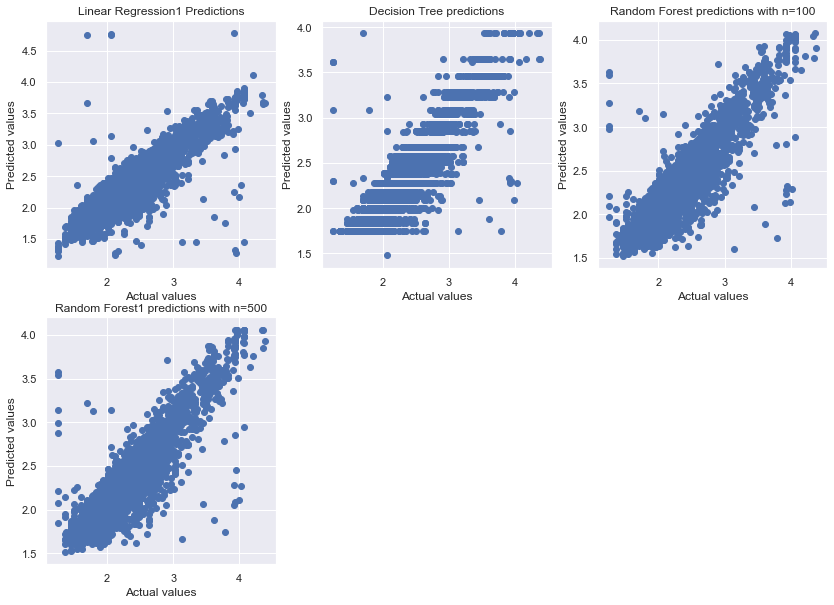

In [99]:
#Ploting to understand the spread of predicted data for modeling 

plt.figure(figsize=(14,10))

plt.subplot(2,3,1)
plt.title('Linear Regression1 Predictions')
plt.scatter(test.iloc[:,7] , prediction_LR)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')

plt.subplot(2,3,2)
plt.title('Decision Tree predictions')
plt.scatter(test.iloc[:,7],prediction_DT)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')

plt.subplot(2,3,3)
plt.title('Random Forest predictions with n=100')
plt.scatter(test.iloc[:,7] , prediction_RF)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')

plt.subplot(2,3,4)
plt.title('Random Forest1 predictions with n=500')
plt.scatter(test.iloc[:,7] , prediction_RF1)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')



In [100]:
# ***********************Implementation on Test dataset *********************
Test_data = pd.read_csv("test.csv")
Test_data.shape

(9914, 6)

In [101]:
## Convert data into proper data type
Test_data['pickup_datetime'] = pd.to_datetime(Test_data['pickup_datetime'], errors='coerce')
Test_data['pickup_datetime'] =  pd.to_datetime(Test_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S UTC')
Test_data.dtypes

pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dtype: object

In [102]:
### Seperate Pickup_datetime column into separate fields year, month, day of the week, etc

Test_data['Year'] = Test_data['pickup_datetime'].dt.year
Test_data['Month'] = Test_data['pickup_datetime'].dt.month
Test_data['Date'] = Test_data['pickup_datetime'].dt.day
Test_data['Day'] = Test_data['pickup_datetime'].dt.dayofweek
Test_data['Hour'] = Test_data['pickup_datetime'].dt.hour
Test_data['Minute'] = Test_data['pickup_datetime'].dt.minute
Test_data.dtypes

pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
Year                               int64
Month                              int64
Date                               int64
Day                                int64
Hour                               int64
Minute                             int64
dtype: object

In [103]:
## Using pickup & Dropoff lat & long calculating Distance 
Test_data['Distance'] = Test_data[['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']].apply(haversine,axis=1)
Test_data.head(5)

pickup_datetime  pickup_longitude  pickup_latitude  \
0 2015-01-27 13:08:24+00:00        -73.973320        40.763805   
1 2015-01-27 13:08:24+00:00        -73.986862        40.719383   
2 2011-10-08 11:53:44+00:00        -73.982524        40.751260   
3 2012-12-01 21:12:12+00:00        -73.981160        40.767807   
4 2012-12-01 21:12:12+00:00        -73.966046        40.789775   

   dropoff_longitude  dropoff_latitude  passenger_count  Year  Month  Date  \
0         -73.981430         40.743835                1  2015      1    27   
1         -73.998886         40.739201                1  2015      1    27   
2         -73.979654         40.746139                1  2011     10     8   
3         -73.990448         40.751635                1  2012     12     1   
4         -73.988565         40.744427                1  2012     12     1   

   Day  Hour  Minute  Distance  
0    1    13       8  2.323259  
1    1    13       8  2.425353  
2    5    11      53  0.618628  
3    5    21      12  1.961033  
4    5    21      12  5.387301

In [104]:
## Feature selection 
drop = ['pickup_datetime','pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude', 'Minute']
Test_data = Test_data.drop(drop, axis = 1)
Test_data.head(5)

passenger_count  Year  Month  Date  Day  Hour  Distance
0                1  2015      1    27    1    13  2.323259
1                1  2015      1    27    1    13  2.425353
2                1  2011     10     8    5    11  0.618628
3                1  2012     12     1    5    21  1.961033
4                1  2012     12     1    5    21  5.387301

Distance


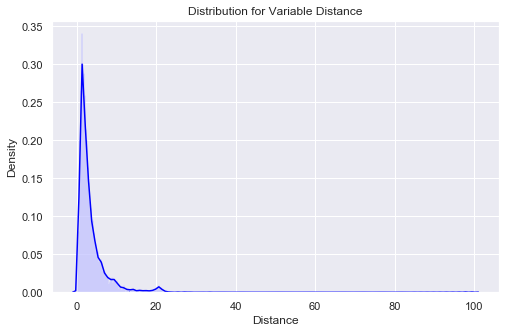

In [105]:
#Normality check of training data is uniformly distributed or not-
for i in ['Distance']:
    print(i)
    sns.distplot(Test_data[i],bins='auto',color='blue')
    plt.title("Distribution for Variable "+i)
    plt.ylabel("Density")
    plt.show()

In [106]:
#since skewness of distance variable is high, apply log transform to reduce the skewness-
Train_data['Distance'] = np.log1p(Train_data['Distance'])

In [107]:
#Normality Re-check to check data is uniformly distributed or not after log transformartion

for i in ['Distance']:
    print(i)
    sns.distplot(Train_data[i],bins='auto',color='green')
    plt.title("Distribution for Variable "+i)
    plt.ylabel("Density")
    plt.show()

Distance


In [108]:
Test_data.head(5)

passenger_count  Year  Month  Date  Day  Hour  Distance
0                1  2015      1    27    1    13  2.323259
1                1  2015      1    27    1    13  2.425353
2                1  2011     10     8    5    11  0.618628
3                1  2012     12     1    5    21  1.961033
4                1  2012     12     1    5    21  5.387301

In [109]:
RF_Test_Model = RandomForestRegressor(n_estimators = 500, random_state = 126).fit(train.iloc[:,0:7],train.iloc[:,7])
amount = RF_Test_Model.predict(Test_data)

Test_data['amount'] = amount

In [110]:
print(Test_data.head(5))

   passenger_count  Year  Month  Date  Day  Hour  Distance    amount
0                1  2015      1    27    1    13  2.323259  3.471638
1                1  2015      1    27    1    13  2.425353  3.611620
2                1  2011     10     8    5    11  0.618628  1.837652
3                1  2012     12     1    5    21  1.961033  2.978327
4                1  2012     12     1    5    21  5.387301  1.704063


In [111]:
fig_size = plt.rcParams['figure.figsize']
fig_size[0] = 10
fig_size[1] = 5
plt.plot(Test_data['amount'])
plt.title('fare_amount')

Text(0.5, 1.0, 'fare_amount')

In [ ]:
#----------------------End of the Project---------------------------#